## First-Level ICD-9 code: Baseline, CNN, LSTM, LSTM-ATT

This workbook peforms the following:
* Read Input file and take a subset of the records
* Preprocess ICD-9 labels, replacing them by their grandparents in the first-level of the hierarchy
* Preprocess clinical notes, building the embedding matrix
* Split files into training, development and testing 
* Super Basic Baseline that predicts the top 4 most common icd-9 codes in the first-level hierarchy
* LSTM, 5 epochs
* LSTM with Attention, 5 epochs
* CNN with 20 epochs
* CNN with 5 epochs

In [2]:
%matplotlib inline
# General imports
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
import random
from collections import Counter, defaultdict
from operator import itemgetter
import matplotlib.pyplot as plt


#keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input, MaxPooling1D, Convolution1D, Embedding
from keras.layers.merge import Concatenate
from keras.models import load_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# Custom functions
%load_ext autoreload
%autoreload 2
import database_selection
import vectorization
import helpers
import icd9_cnn_model
import lstm_model


Using TensorFlow backend.


## Read Input File

In [4]:
#reading file
full_df = pd.read_csv('../data/disch_notes_all_icd9.csv',
                 names = ['HADM_ID', 'SUBJECT_ID', 'DATE', 'ICD9','TEXT'])
print 'Full shape: ', full_df.shape
# taking just a subset of the records for developing models
df = full_df.sample(frac=0.1).reset_index(drop=True)
print 'Subset shape: ', df.shape
df.head(10)

Full shape:  (52696, 5)
Subset shape:  (5270, 5)


,HADM_ID,SUBJECT_ID,DATE,ICD9,TEXT
0,103293,45419,2174-04-14 00:00:00,20500 2866 27788 51881 5845 4321 34982 43491 5...,Admission Date: [**2174-3-18**] ...
1,124093,13653,2199-01-14 00:00:00,41071 4280 9975 5849 5789 40391 4240 41401 25040,Admission Date: [**2199-1-8**] Discharg...
2,183748,30946,2167-01-02 00:00:00,1623 4928 2765 2851 3962 9982 4019 7140,Admission Date: [**2166-12-29**] ...
3,193193,29365,2124-08-11 00:00:00,1970 486 1987 79902 4589 7850,Admission Date: [**2124-8-6**] D...
4,100361,8735,2145-05-20 00:00:00,55221 42832 1179 5609 4280 42789 25000 7885 4019,Admission Date: [**2145-5-7**] D...
5,107538,11470,2142-10-13 00:00:00,56969 5789 1550 2800 5712 5569 53081 25000,Admission Date: [**2142-10-12**] ...
6,109412,6675,2192-08-16 00:00:00,4240 4019 2720,Admission Date: [**2192-8-8**] D...
7,148331,11686,2185-12-23 00:00:00,51881 2848 99590 5849 40391 5859 70703 9998 42...,Admission Date: [**2185-12-5**] ...
8,196657,2063,2140-10-07 00:00:00,4260 4280 41401 41072 42731,Admission Date: [**2140-10-6**] ...
9,144689,92788,2148-12-23 00:00:00,4210 5845 51881 49121 9972 2761 2639 04109 428...,Admission Date: [**2148-12-5**] ...


## Pre processing and Exploring first level ICD 9 codes in the Hierarchy
instead of finding out the top 20 leave icd-9 codes and filter records based on that   
we will use all records and replace the leave icd-9 codes with its grandparents code in the first level of the hierarchy

### Replacing leave icd-9 codes with their grandparent icd-9 code in the first level of the hierarchy

Source: https://github.com/sirrice/icd9   
The code above let's you see the ICD-9 hierarchy and traverse it, getting the parents (path) of a node, the children of a node, siblings, etc. (well documented in its README file).  

From looking at the top of the hierarchy, these are the ICD9-codes that are in the first level of the hierarchy.
```
001-139 INFECTIOUS AND PARASITIC DISEASES 
140-239 NEOPLASMS 
240-279 ENDOCRINE, NUTRITIONAL AND METABOLIC DISEASES, AND IMMUNITY DISORDERS 
290-319 MENTAL DISORDERS 
320-389 DISEASES OF THE NERVOUS SYSTEM AND SENSE ORGANS 
390-459 DISEASES OF THE CIRCULATORY SYSTEM 
460-519 DISEASES OF THE RESPIRATORY SYSTEM 
520-579 DISEASES OF THE DIGESTIVE SYSTEM 
580-629 DISEASES OF THE GENITOURINARY SYSTEM 
630-679 COMPLICATIONS OF PREGNANCY, CHILDBIRTH, AND THE PUERPERIUM 
680-709 DISEASES OF THE SKIN AND SUBCUTANEOUS TISSUE 
710-739 DISEASES OF THE MUSCULOSKELETAL SYSTEM AND CONNECTIVE TISSUE 
760-779 CERTAIN CONDITIONS ORIGINATING IN THE PERINATAL PERIOD 
780-789 SYMPTOMS 
790-796 NONSPECIFIC ABNORMAL FINDINGS 
797 Senility without mention of psychosis
798 Sudden death, cause unknown
799 Other ill-defined and unknown causes of morbidity and mortality
800-999 INJURY AND POISONING 
```

The way that ICD9-codes are coded makes easy to find out which icd9-code code is the granparent in the first level,
for example:
```
leave-code  code-at-first-level
64833    -> 630-679
4019     -> 390-459
```

The first three charachters of the leave icd9-code can be used to find out which is the grandparent icd-code in the first level

In [6]:
ICD9_FIRST_LEVEL = [
    '001-139','140-239','240-279','290-319', '320-389', '390-459','460-519', '520-579', '580-629', 
    '630-679', '680-709','710-739', '760-779', '780-789', '790-796', '797', '798', '799', '800-999' ]
N_TOP = len(ICD9_FIRST_LEVEL)
# replacing leave ICD9 codes with the grandparents
df['ICD9'] = df['ICD9'].apply(lambda x: helpers.replace_with_grandparent_codes(x,ICD9_FIRST_LEVEL))
df.head(10)

,HADM_ID,SUBJECT_ID,DATE,ICD9,TEXT
0,150589,20305,2158-09-10 00:00:00,760-779,Admission Date: [**2158-9-6**] Discharg...
1,143886,61195,2111-11-12 00:00:00,240-279 001-139 390-459 290-319 460-519 800-999,Admission Date: [**2111-11-9**] ...
2,170484,22121,2140-01-31 00:00:00,760-779,Admission Date: [**2140-1-21**] Dischar...
3,187189,15302,2115-12-09 00:00:00,140-239 390-459 800-999 320-389,Admission Date: [**2115-12-2**] Dischar...
4,187761,55030,2201-04-08 00:00:00,240-279 140-239 290-319,Admission Date: [**2201-4-2**] D...
5,112427,12789,2161-02-21 00:00:00,390-459 800-999,Admission Date: [**2161-2-14**] Dischar...
6,101719,24766,2156-01-20 00:00:00,240-279 390-459 800-999,Admission Date: [**2156-1-17**] Dischar...
7,127002,17496,2132-01-15 00:00:00,240-279 390-459 290-319 520-579 800-999 140-23...,Admission Date: [**2131-12-26**] ...
8,196473,44374,2107-03-27 00:00:00,240-279 390-459 320-389 800-999,"Name: [**Known lastname 7845**],[**Known firs..."
9,143264,42794,2127-05-06 00:00:00,001-139 390-459 290-319 460-519 800-999 780-78...,Admission Date: [**2127-4-30**] ...


In [7]:
#counts by icd9_codes
icd9_codes = Counter()
for label in df['ICD9']:
    for icd9_code in label.split():
        icd9_codes[icd9_code] += 1
number_icd9_first_level = len (icd9_codes)
print icd9_codes
print 'Number of icd9 codes in the first level that have notes in the dataset:', number_icd9_first_level

Counter({'390-459': 4075, '240-279': 3431, '290-319': 2801, '460-519': 2431, '800-999': 2198, '580-629': 2129, '520-579': 1995, '780-789': 1610, '320-389': 1582, '001-139': 1409, '710-739': 975, '140-239': 895, '680-709': 577, '760-779': 560, '790-796': 472, '799': 143, '630-679': 17})
Number of icd9 codes in the first level that have notes in the dataset: 17


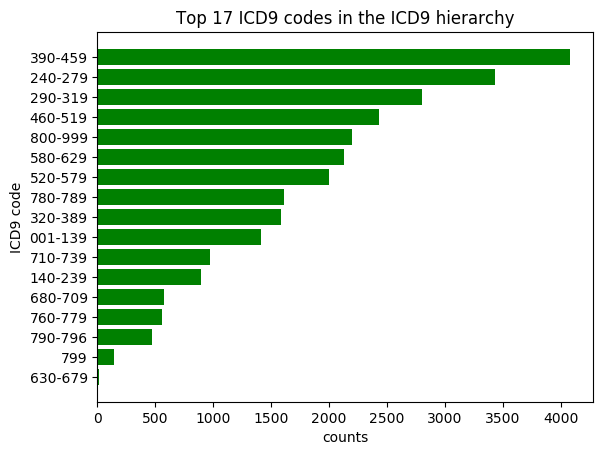

In [8]:
codes_counts =icd9_codes.items()
codes_counts.sort(key=itemgetter(1), reverse=True)
icd9_labels, values = zip(*codes_counts)
indexes = np.arange(len(icd9_labels))
plt.rcdefaults()
fig,ax = plt.subplots()
ax.barh(indexes, values,  align='center', color='green', ecolor='black')
ax.set_yticks(indexes)
ax.set_yticklabels(icd9_labels)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('counts')
ax.set_ylabel('ICD9 code')
ax.set_title('Top ' + str(number_icd9_first_level) + ' ICD9 codes in the ICD9 hierarchy')
plt.show()

In [9]:
#preprocess icd9 codes to vectors 
top_codes = ICD9_FIRST_LEVEL
labels = vectorization.vectorize_icd_column(df, 'ICD9', top_codes)
print 'sample of vectorized icd9 labels: ', labels[0]


sample of vectorized icd9 labels:  [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]


## Pre process Notes

In [10]:
#preprocess notes
MAX_VOCAB = None # to limit original number of words (None if no limit)
MAX_SEQ_LENGTH = 5000 # to limit length of word sequence (None if no limit)
df.TEXT = vectorization.clean_notes(df, 'TEXT')
data_vectorized, dictionary, MAX_VOCAB = vectorization.vectorize_notes(df.TEXT, MAX_VOCAB, verbose = True)
data, MAX_SEQ_LENGTH = vectorization.pad_notes(data_vectorized, MAX_SEQ_LENGTH)

print("Final Vocabulary: %s" % MAX_VOCAB)
print("Final Max Sequence Length: %s" % MAX_SEQ_LENGTH)

Vocabulary size: 44938
Average note length: 1640.78330171
Max note length: 8867
Final Vocabulary: 44938
Final Max Sequence Length: 5000


In [11]:
EMBEDDING_DIM = 100 # given the glove that we chose
EMBEDDING_MATRIX= []

In [12]:
#creating glove embeddings
EMBEDDING_LOC = '../data/notes.100.txt' # location of embedding
EMBEDDING_MATRIX, embedding_dict = vectorization.embedding_matrix(EMBEDDING_LOC,
                                                                  dictionary, EMBEDDING_DIM, verbose = True, sigma=True)


('Vocabulary in notes:', 44938)
('Vocabulary in original embedding:', 21056)
('Vocabulary intersection:', 19971)


## Split Files

In [13]:
#split sets
X_train, X_val, X_test, y_train, y_val, y_test = helpers.train_val_test_split(
    data, labels, val_size=0.2, test_size=0.1, random_state=101)
print("Train: ", X_train.shape, y_train.shape)
print("Validation: ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)

('Train: ', (3688, 5000), (3688, 19))
('Validation: ', (1054, 5000), (1054, 19))
('Test: ', (528, 5000), (528, 19))


In [14]:
# Delete temporary variables to free some memory
del df, data, labels

## Super Basic Baseline with top 4
Always predict top 4

In [14]:
# finding out the top icd9 codes
top_4_icd9 = icd9_codes.most_common(4)
print "most common 4 icd9_codes: ", top_4_icd9
top_4_icd9_label = ' '.join(code for code,count in top_4_icd9 )
print 'label for the top 4 icd9 codes: ', top_4_icd9_label

most common 4 icd9_codes:  [('390-459', 4149), ('240-279', 3476), ('290-319', 2809), ('460-519', 2481)]
label for the top 4 icd9 codes:  390-459 240-279 290-319 460-519


In [15]:
#converting ICD9 prediction to a vector
top4_icd9_vector =  vectorization.vectorize_icd_string(top_4_icd9_label, ICD9_FIRST_LEVEL)
print ICD9_FIRST_LEVEL
print top4_icd9_vector

['001-139', '140-239', '240-279', '290-319', '320-389', '390-459', '460-519', '520-579', '580-629', '630-679', '680-709', '710-739', '760-779', '780-789', '790-796', '797', '798', '799', '800-999']
[0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0]


In [16]:
## assign icd9_prediction_vector to every discharge
train_y_hat_baseline = [top4_icd9_vector]* len (y_train)
dev_y_hat_baseline = [top4_icd9_vector]* len (y_val)

In [17]:
helpers.show_f1_score(y_train, train_y_hat_baseline, y_val, dev_y_hat_baseline)

F1 scores
threshold | training | dev  
0.020:      0.532      0.526
0.030:      0.532      0.526
0.040:      0.532      0.526
0.050:      0.532      0.526
0.055:      0.532      0.526
0.058:      0.532      0.526
0.060:      0.532      0.526
0.080:      0.532      0.526
0.100:      0.532      0.526
0.200:      0.532      0.526
0.300:      0.532      0.526
0.500:      0.532      0.526


## Basic LSTM 

In [16]:
reload(lstm_model)
#### build model
l_model = lstm_model.build_lstm_model (input_seq_length=MAX_SEQ_LENGTH, max_vocab = MAX_VOCAB,
                             external_embeddings = True, embedding_trainable =True,
                             embedding_dim=EMBEDDING_DIM,embedding_matrix=EMBEDDING_MATRIX,                             
                             num_classes=N_TOP, training_dropout_keep_prob=0.5 )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 5000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 5000, 100)         4493900   
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 19)                969       
Total params: 4,525,069
Trainable params: 4,525,069
Non-trainable params: 0
_________________________________________________________________
None


In [17]:
l_model.fit(X_train, y_train, batch_size=50, epochs=5, validation_data=(X_val, y_val), verbose=1)

Train on 3688 samples, validate on 1054 samples
Epoch 1/5
3688/3688 [==============================] - 370s - loss: 0.5363 - acc: 0.7246 - val_loss: 0.4363 - val_acc: 0.7881

In [18]:
pred_train = l_model.predict(X_train, batch_size=100)
pred_dev = l_model.predict(X_val, batch_size=100)
helpers.show_f1_score(y_train, pred_train, y_val, pred_dev)

F1 scores
threshold | training | dev  
0.020:      0.483      0.481
0.030:      0.502      0.501
0.040:      0.521      0.519
0.050:      0.533      0.531
0.055:      0.539      0.537
0.058:      0.542      0.540
0.060:      0.544      0.541
0.080:      0.561      0.556
0.100:      0.576      0.571
0.200:      0.630      0.626
0.300:      0.648      0.646
0.400:      0.632      0.622
0.500:      0.550      0.542
0.600:      0.471      0.464
0.700:      0.381      0.376


## LSTM with Attention

In [20]:
import icd9_lstm_att_model

In [21]:
reload(icd9_lstm_att_model)
#### build model
latt_model = icd9_lstm_att_model.build_lstm_att_model (input_seq_length=MAX_SEQ_LENGTH, max_vocab = MAX_VOCAB,
                             external_embeddings = True, embedding_trainable =True,
                             embedding_dim=EMBEDDING_DIM,embedding_matrix=EMBEDDING_MATRIX,                             
                             num_classes=N_TOP, training_dropout_keep_prob=0.5 )

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 5000)          0                                            
____________________________________________________________________________________________________
Embeddng (Embedding)             (None, 5000, 100)     4493900     input_2[0][0]                    
____________________________________________________________________________________________________
lstm_2 (LSTM)                    (None, 5000, 50)      30200       Embeddng[0][0]                   
____________________________________________________________________________________________________
time_distributed_1 (TimeDistribu (None, 5000, 50)      2550        lstm_2[0][0]                     
___________________________________________________________________________________________

attention_util.py:22: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, use_bias=False)`
  att = TimeDistributed(Dense(1, bias=False))(u_it)
attention_util.py:29: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  s_i =merge([att, inputs], mode='dot', dot_axes=(1,1), name='s_i_dot')
/home/zenla/anaconda2/lib/python2.7/site-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


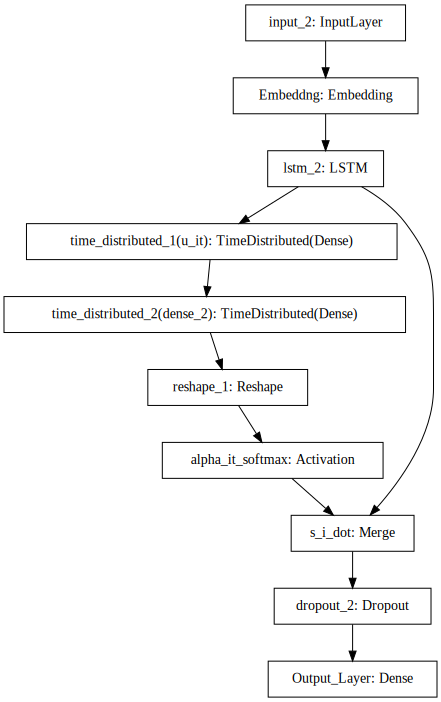

In [22]:
SVG(model_to_dot(latt_model).create(prog='dot', format='svg'))

In [23]:
model_lst_att_fit = latt_model.fit(X_train, y_train, batch_size=50, epochs=1, validation_data=(X_val, y_val), verbose=1)

Train on 3688 samples, validate on 1054 samples
Epoch 1/1
3688/3688 [==============================] - 326s - loss: 0.5269 - acc: 0.7356 - val_loss: 0.4472 - val_acc: 0.7819

In [25]:
model_lst_att_fit = latt_model.fit(X_train, y_train, batch_size=50, epochs=4, validation_data=(X_val, y_val), verbose=1)

Train on 3688 samples, validate on 1054 samples
Epoch 1/4
3688/3688 [==============================] - 329s - loss: 0.4692 - acc: 0.7667 - val_loss: 0.4254 - val_acc: 0.7962

In [26]:
pred_train = latt_model.predict(X_train, batch_size=100)
pred_dev = latt_model.predict(X_val, batch_size=100)
helpers.show_f1_score(y_train, pred_train, y_val, pred_dev)

F1 scores
threshold | training | dev  
0.020:      0.479      0.477
0.030:      0.501      0.499
0.040:      0.516      0.514
0.050:      0.529      0.527
0.055:      0.535      0.533
0.058:      0.539      0.537
0.060:      0.541      0.540
0.080:      0.563      0.560
0.100:      0.582      0.579
0.200:      0.651      0.646
0.300:      0.676      0.670
0.400:      0.660      0.653
0.500:      0.604      0.597
0.600:      0.507      0.503
0.700:      0.363      0.361


In [52]:
latt_model.save('models/latt_model_5_epochs_5k.h5')

## CNN for text classification

Based on the following papers and links:
* "Convolutional Neural Networks for Sentence Classification"   
* "A Sensitivity Analysis of (and Practitioners� Guide to) Convolutional Neural Networks for Sentence Classification"
* http://www.wildml.com/2015/11/understanding-convolutional-neural-networks-for-nlp/
* https://github.com/alexander-rakhlin/CNN-for-Sentence-Classification-in-Keras/blob/master/sentiment_cnn.py
* http://www.wildml.com/2015/12/implementing-a-cnn-for-text-classification-in-tensorflow/
* https://github.com/dennybritz/cnn-text-classification-tf/blob/master/text_cnn.py

In [15]:
reload(icd9_cnn_model)
#### build model
model = icd9_cnn_model.build_icd9_cnn_model (input_seq_length=MAX_SEQ_LENGTH, max_vocab = MAX_VOCAB,
                             external_embeddings = False,
                             embedding_dim=EMBEDDING_DIM,embedding_matrix=EMBEDDING_MATRIX,
                             num_filters = 100, filter_sizes=[2,3,4,5],
                             training_dropout_keep_prob=0.5,
                             num_classes=N_TOP )

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 5000)          0                                            
____________________________________________________________________________________________________
embedding (Embedding)            (None, 5000, 100)     4514500     input_1[0][0]                    
____________________________________________________________________________________________________
conv1d_1 (Conv1D)                (None, 4999, 100)     20100       embedding[0][0]                  
____________________________________________________________________________________________________
conv1d_2 (Conv1D)                (None, 4998, 100)     30100       embedding[0][0]                  
___________________________________________________________________________________________

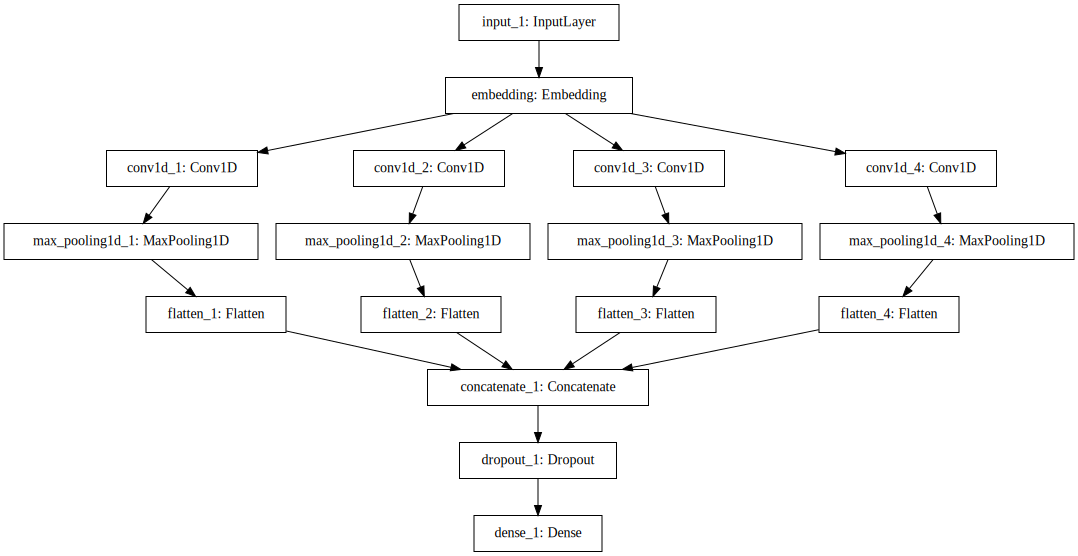

In [16]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [29]:
# Train the model
model.fit(X_train, y_train, batch_size=50, epochs=20, validation_data=(X_val, y_val), verbose=2)

Train on 3688 samples, validate on 1054 samples
Epoch 1/20
102s - loss: 0.3680 - acc: 0.8344 - val_loss: 0.3533 - val_acc: 0.8430
Epoch 2/20
103s - loss: 0.3595 - acc: 0.8408 - val_loss: 0.3467 - val_acc: 0.8470
Epoch 3/20
103s - loss: 0.3508 - acc: 0.8456 - val_loss: 0.3412 - val_acc: 0.8526
Epoch 4/20
103s - loss: 0.3456 - acc: 0.8523 - val_loss: 0.3353 - val_acc: 0.8578
Epoch 5/20
103s - loss: 0.3370 - acc: 0.8575 - val_loss: 0.3325 - val_acc: 0.8587
Epoch 6/20
103s - loss: 0.3325 - acc: 0.8600 - val_loss: 0.3275 - val_acc: 0.8626
Epoch 7/20
103s - loss: 0.3270 - acc: 0.8638 - val_loss: 0.3266 - val_acc: 0.8646
Epoch 8/20
102s - loss: 0.3227 - acc: 0.8669 - val_loss: 0.3246 - val_acc: 0.8668
Epoch 9/20
102s - loss: 0.3173 - acc: 0.8699 - val_loss: 0.3231 - val_acc: 0.8689
Epoch 10/20
102s - loss: 0.3118 - acc: 0.8728 - val_loss: 0.3216 - val_acc: 0.8702
Epoch 11/20
102s - loss: 0.3080 - acc: 0.8752 - val_loss: 0.3191 - val_acc: 0.8712
Epoch 12/20
102s - loss: 0.3029 - acc: 0.8802 - 

In [30]:
pred_train = model.predict(X_train, batch_size=50)
pred_dev = model.predict(X_val, batch_size=50)
# perform evaluation
helpers.show_f1_score(y_train, pred_train, y_val, pred_dev)

F1 scores
threshold | training | dev  
0.020:      0.546      0.534
0.030:      0.569      0.555
0.040:      0.590      0.574
0.050:      0.611      0.591
0.055:      0.620      0.599
0.058:      0.627      0.604
0.060:      0.631      0.607
0.080:      0.664      0.632
0.100:      0.692      0.652
0.200:      0.792      0.724
0.300:      0.849      0.756
0.400:      0.868      0.762
0.500:      0.861      0.753
0.600:      0.838      0.741
0.700:      0.797      0.710


In [54]:
model.save('models/cnn_20_epochs.h5')
#model = load_model('models/cnn_20_epochs.h5')


### Results from running CNN with just 5 epochs
```
Train on 3688 samples, validate on 1054 samples
Epoch 1/5
103s - loss: 0.5728 - acc: 0.7669 - val_loss: 0.4375 - val_acc: 0.7938
Epoch 2/5
102s - loss: 0.4283 - acc: 0.7935 - val_loss: 0.3976 - val_acc: 0.8152
Epoch 3/5
103s - loss: 0.4001 - acc: 0.8101 - val_loss: 0.3801 - val_acc: 0.8245
Epoch 4/5
103s - loss: 0.3885 - acc: 0.8196 - val_loss: 0.3721 - val_acc: 0.8289
Epoch 5/5
103s - loss: 0.3775 - acc: 0.8264 - val_loss: 0.3604 - val_acc: 0.8383

F1 scores
threshold | training | dev  
0.020:      0.517      0.508
0.030:      0.532      0.524
0.040:      0.545      0.537
0.050:      0.556      0.547
0.055:      0.561      0.553
0.058:      0.565      0.556
0.060:      0.567      0.558
0.080:      0.591      0.582
0.100:      0.610      0.599
0.200:      0.672      0.660
0.300:      0.703      0.691
0.400:      0.705      0.691
0.500:      0.673      0.664
0.600:      0.612      0.608
0.700:      0.523      0.526
```